## Data Analysis 2019/2020 - Coursework 2 
***
## Deadline: Thursday 21st Nov 2pm

#### Tips

This coursework assesses the learning outcomes for Block B.

These assessments are equivalent to an exam:

- Submit your work via Turn-It-In on Learning Central. Note that you will need to upload your final notebook exported as a html file. **Don't forget to click `run all` before you export it**. You can constantly update this document until the deadline.
- Please put your name as the filename of the Jupyter notebook.
- Please also take note of the University’s policy on plagiarism, which is outlined in your student handbook.

Marks are awarded for 
- Ability to identify the correct statistical method with sound reasoning.
- Evidence of knowledge of the assumptions made or infered from the question.
- Application of the statistical method, including correct treatment of the given / inferred data.  
- Critical explanations and interpretation of the results.
- All working, coding, figures etc must be included and you will need to accompany this with a succinct and tidy report explaining what you did and why.
- Full marks can only be awarded where there is proof that the student understands the statistics and the data set that they are being asked to explore. Code, figures and any mathematics carried out count as workings, and must be included in the 
Jupyter notebook to obtain the relevant marks.  

- Don't worry about how your code looks - marks are not given for pretty code, but rather for the approach used in solving the problem, your reasoning, explanation and answer

***
## QUESTION 1 
***

An MSc student working with Professor Whitworth in the field of star formation is performing computer simulations in which she is trying to create ‘multiple’ stellar systems — i.e. systems with 2 stars (binaries, $B$), 3 stars (triples, $T$) or higher number groups.  

The goal of her experiment is to see how often star forming clouds (protostellar cores) give birth to multiple systems. Unfortunately, these simulations are extremely computationally expensive (each one takes 3 weeks of supercomputer time), and she is only able to run 3 simulations in total during her masters — each one following the evolution of a different core.  Each simulation is run until the core collapses under its own weight to form either a single star (S) or some multiple system, and accretes a given amount of mass from the core.  

She finds that in her 3 simulations, only single stars are formed. The common form of expressing the multiplicity properties of stars is the ‘multiplicity fraction’, $m$, which is given by

$m = \dfrac{(B + T + …)}{(S + B + T)}$ 

which is simply the probability of an stellar system being a multiple system.  In our local patch of the galaxy, the value of $m$ is observed to be roughly 0.5, but this has only been measured for stars that are more massive than those found in the modeller’s simulations. What can the researcher say about the mean and standard deviation of $m$ given the outcome of her simulations?

**Hint**: you will need to use Bayes theorem. Your result will depend on your choice of prior, so be sure to discuss your choice.

[40 marks]

#### Answer:

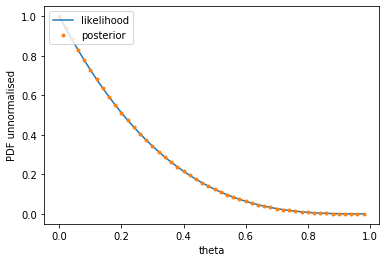

In [1]:
import numpy as np
import pylab as plt
import math

%matplotlib inline

nu = 0
N = 3

# for plotting
nsteps=50

x = np.arange(0,1,1./nsteps)


likelihood = (math.factorial(N)/(math.factorial(nu)*(math.factorial(N-nu))))*x**nu * (1 - x)**(N - nu) 

prior = [1.0 for i in range(0,len(x))]

# posterior = likelihood x prior
posterior = likelihood*prior

#let's save an array of x and y for working out credible intervals later

plt.plot(x,likelihood,label='likelihood')
plt.plot(x,posterior,'.',label='posterior')

#plt.xlim(0,1)
plt.ylabel('PDF unnormalised')
plt.xlabel('theta')
plt.legend(loc='upper left')

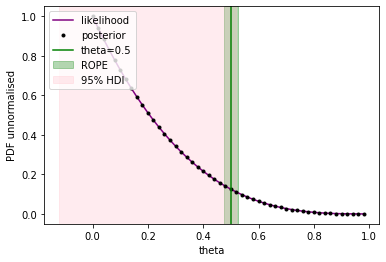

In [2]:
a = 1.
b = 1.
# posterior mean + std from analytical approx in lecture notes
posterior_mean = np.float((nu+a)/(N+a+b))
posterior_std = np.sqrt( posterior_mean*(1-posterior_mean)/(nu+a+N-nu+b+1))

# set up credible intervals = mean + / - 1.96 x sigma
HDI_a = posterior_mean+1.96*posterior_std
HDI_b = posterior_mean-1.96*posterior_std

plt.plot(x,likelihood,label='likelihood',c='purple')
plt.plot(x,posterior,'.',label='posterior',c='black',lw=2)

# this makes nice shaded regions to show off where the ROPE is
plt.axvspan(0.5-0.025,0.5+0.025,color='green',label='ROPE',alpha=0.3)
plt.axvspan(HDI_b,HDI_a,color='pink',label='95% HDI',alpha=0.3)

plt.axvline(0.5,color='green',label='theta=0.5')
#plt.ylim(0,6e-14)
plt.ylabel('PDF unnormalised')
plt.xlabel('theta')
plt.legend(loc='upper left')

In [ ]:
# It could be that the simulation doesnt have enough mass for multiple systems to form. As we can see
# in her results that there is far more proability of single star systems forming.

***
## QUESTION 2
***

Professor Dumbledore, studying the extinction of the elephant bird, discovers a new set of egg remnants in an unexplored valley in Madagascar. The remnants are radio carbon dayed and found to have the following ages in years:

2141.22, 1781.15, 1523.37, 1816.90, 1932.29, 1541.21, 720.782, 1026.22, 1687.22, 2460.59

Professor Snape however did a previous study in the next valley where he found eggs that were on average 1200 years old, following a normal distribution with standard deviation of 300 years. 

What is the mean and standard deviation of the age of elephant bird eggs based on this information?

**Tip a** Write down an analytical expression for the mean and standard deviation of the age of the new eggs for the posterior distribution that takes into account both Professor Dumbeldore's new data and the previous age estimate from Professor Snape (all the equations are given in the notes).

**Tip b**: Write an MCMC algorithm from scratch and use it to create a posterior distribution for the mean age of the eggs.  Discuss your results.

[75 marks]

#### Answer:

Text(0, 0.5, 'Number data sets')

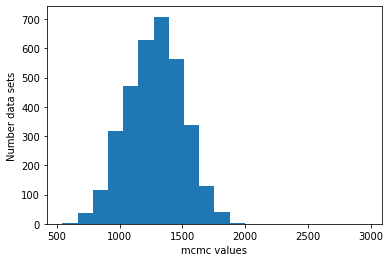

In [3]:
import numpy as np
import pylab as plt
import math
from scipy.stats import norm



def var_hat(var0, var, n):
    value =(var0*(var/n))/(var0+(var/n))
    return value

def mean_theta(var0, var, n, X, mean):
    value =(var0/(var0+(var/n)))*X+((var/n)/(var0+(var/n)))*mean
    return value

def prob_theta(var0, var, n, X, mean, theta):
    P_mean_theta = np.exp(-1*(((X-theta)**2)/(2*(var/n))))
    P_theta = np.exp(-1*(((theta-mean)**2)/var0))
    #P_theta_mean = float(P_mean_theta * P_theta)
    return P_theta

age = [2141.22, 1781.15, 1523.37, 1816.90, 1932.29, 1541.21, 720.782, 1026.22, 1687.22, 2460.59]

variance = (np.max(age) - np.min(age))**2
variance0 = (300**2)
n = len(age)
var_n = variance/n
std = np.sqrt(variance/n)
x = np.linspace(500,2300,1000)
mean = np.sum(age)/n
mean0 = 1200


def mcmc(var0,var,n,X,mean,nsteps):
    accepted = []
    rejected = []
    values = []
    random_values = np.random.normal(X,var,size = nsteps)
    accepted.append(random_values[0])
    values.append(random_values[0])
    for ii in range(1, nsteps):
        theta_current = accepted[-1]
        theta_pro = random_values[ii]
        values.append(theta_pro)
        prob_theta_pro = prob_theta(var0, var, n, X, mean, theta_pro)
        prob_theta_current = prob_theta(var0, var, n, X, mean, theta_current)
        p_move = min(prob_theta_pro/prob_theta_current,1)
        
        if p_move< 1:
            urnd = np.random.uniform()
            if urnd <= p_move:
                accepted.append(theta_pro)
                
            else:
                rejected.append(theta_pro)
        else:
            accepted.append(theta_pro)
    return np.array(accepted)

mcmc_array = mcmc(variance0, std, n , mean, mean0, 10000)
plt.hist(mcmc_array,bins=20)

plt.xlabel('mcmc values')
plt.ylabel('Number data sets')

1293.8052252589193 243.29408380939594


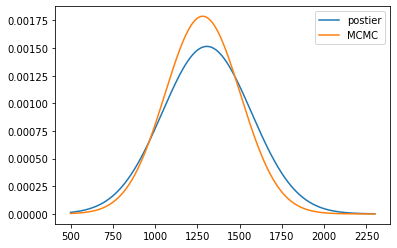

In [4]:
post_var = var_hat(variance0, variance, n)
post_mean = mean_theta(variance0, variance, n, mean, mean0)
post_std = np.sqrt(post_var)
mcmc_var = np.var(mcmc_array)
mcmc_std = np.sqrt(mcmc_var)
mcmc_mean = np.mean(mcmc_array)
average_mean = (post_mean+mcmc_mean)/2
average_std = (post_std+mcmc_std)/2
x = np.linspace(500,2300,1000)
post_normal = norm.pdf(x,post_mean, post_std)
mcmc_normal = norm.pdf(x,mcmc_mean, mcmc_std)
plt.plot(x, post_normal, label = 'postier')
plt.plot(x, mcmc_normal, label = 'MCMC')
plt.legend(loc = 'upper right')
print(average_mean,average_std)

our average mean is 1293 and average std is 243

## Question 3
***

The government wants to investigate graduate earnings, and so they collect information on graduate earnings (in £1000s) compared to the average UK salary $y$ as well as the number of years after they graduated $x$. This data is found in DataAnalysis_datafile_2.dat (available on learning central and in the microsoft.azure notebook directory). 

Perform a straight line fit, calculating, and reporting all the errors.  

Next perform a Monte Carlo process whereby you use random sampling to make numerical estimations of unknown parameters. Do this by randomly sampling from the $y$ values, using the data $y$ and its associated errors to create a new data set.  Recalculate the slope and intersect from the new (randomly sampled) data set. Repeat this many different times, using the results of each fit to work out the mean and standard deviation for the fit parameters. 

[45 marks]

#### Answer:

-15.136826159064332 5.945859805906803
0.3088426574429055 0.03813595950233012


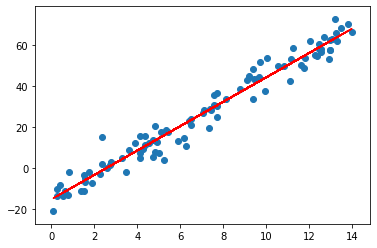

In [3]:
import csv
import numpy as np
import pylab as plt

with open('/home/cot12/Downloads/DataAnalysis_datafile_2.dat') as csvfile:   # open csv file
    readcsv = csv.reader(csvfile, delimiter = ' ') # read file 
    datax = []
    datay = []
    error_y = []
    for row in readcsv:
        x = row[0]
        y = row[1]
        error = row[2]
        datax.append(x)
        datay.append(y)
        error_y.append(error)
    datax.pop(0)
    datay.pop(0)
    error_y.pop(0)

x_array = np.array(datax, dtype = np.float)
value_x_array = np.sum(x_array)
y_array = np.array(datay, dtype = np.float)
value_y_array = np.sum(y_array)
x2_array = np.square(x_array)
value_x2_array = np.sum(x2_array)
xy_array = np.multiply(x_array,y_array)
value_xy_array = np.sum(xy_array)
N = len(datax)
    
A = ((value_x2_array * value_y_array) - (value_x_array * value_xy_array))/((N * value_x2_array) - (value_x_array **2))
B = ((N*value_xy_array) - (value_x_array*value_y_array))/ (N * value_x2_array - (value_x_array **2))
y_line = A+B*x_array
error_A = 1.6*np.sqrt((value_x2_array)/((N * value_x2_array) - (value_x_array **2)))
error_B = 1.6*np.sqrt((N)/((N * value_x2_array) - (value_x_array **2)))
print(A,B)
print(error_A, error_B)
plt.plot(x_array, y_line, c = 'r')
plt.scatter(x_array,y_array)
plt.show()


In [6]:
# This is what was done before I saw the email saying not to bother with it.